In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sn
import skimage.io
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import ResNet50
from tensorflow.keras.layers import Dense, Flatten, Dropout,BatchNormalization ,Activation
from tensorflow.keras.models import Model, Sequential
from tensorflow.keras.callbacks import ReduceLROnPlateau, ModelCheckpoint, EarlyStopping
from tensorflow.keras.optimizers import Adam

2024-11-21 03:54:07.196626: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1732190047.210920   11709 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1732190047.215160   11709 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-11-21 03:54:07.232420: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [ ]:
print("Built with CUDA:", tf.test.is_built_with_cuda())

# 列出所有可用設備
print("Physical Devices:", tf.config.list_physical_devices())

# 列出 GPU 設備
print("GPUs:", tf.config.list_physical_devices('GPU'))

Built with CUDA: True
Physical Devices: [PhysicalDevice(name='/physical_device:CPU:0', device_type='CPU'), PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]
GPUs: [PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]
Physical Devices: [PhysicalDevice(name='/physical_device:CPU:0', device_type='CPU'), PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]
Using GPU: PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')


In [7]:
train_datagen = ImageDataGenerator(
    rescale = 1./255,
    validation_split = 0.2,
    rotation_range=5,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    horizontal_flip=True,
    vertical_flip=True,
    fill_mode='nearest'
)

valid_datagen = ImageDataGenerator(
    rescale = 1./255, 
    validation_split = 0.2
)

test_datagen  = ImageDataGenerator(
    rescale = 1./255
)

In [4]:
train_dataset  = train_datagen.flow_from_directory(
    directory = '../data_storage/fer2013/train',
    target_size = (224,224),
    class_mode = 'categorical',
    subset = 'training',
    batch_size = 64
)

Found 22968 images belonging to 7 classes.


In [8]:
valid_dataset = valid_datagen.flow_from_directory(
    directory = '../data_storage/fer2013/train',
    target_size = (224,224),
    class_mode = 'categorical',
    subset = 'validation',
    batch_size = 64
)

Found 5741 images belonging to 7 classes.


In [9]:
test_dataset = test_datagen.flow_from_directory(
    directory = '../data_storage/fer2013/test',
    target_size = (224,224),
    class_mode = 'categorical',
    batch_size = 64
)

Found 7178 images belonging to 7 classes.


(224, 224, 3)
(1, 224, 224, 3)


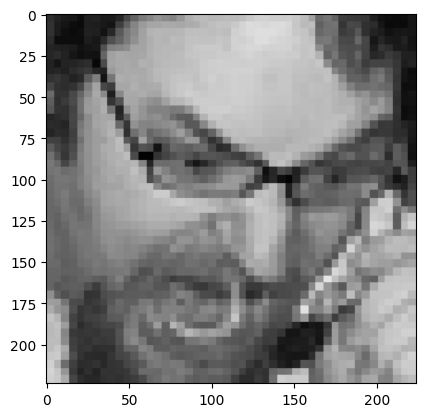

In [10]:
from tensorflow.keras.preprocessing import image
img = image.load_img("../data_storage/fer2013/test/angry/PrivateTest_10131363.jpg",target_size=(224,224))
img = np.array(img)
plt.imshow(img)
print(img.shape)

img = np.expand_dims(img, axis=0)
print(img.shape)

In [11]:
from tensorflow.keras.models import load_model
print(img.shape)

(1, 224, 224, 3)


In [13]:
base_model = tf.keras.applications.ResNet50(input_shape=(224,224,3),include_top=False,weights="imagenet")

In [14]:
for layer in base_model.layers[:-4]:
    layer.trainable=False

In [15]:
from tensorflow.keras.layers import Dense, Input, Dropout, GlobalAveragePooling2D, Flatten, Conv2D, BatchNormalization, Activation, MaxPooling2D
from tensorflow.keras.models import Model, Sequential
from tensorflow.keras.optimizers import Adam

# number of possible label values
nb_classes = 7

# Initialising the CNN
model = Sequential()

# 1 - Convolution 
# extract relevant features from the images
model.add(base_model) #adding base model of ResNet50
model.add(BatchNormalization())  
model.add(Activation('relu'))
model.add(Dropout(0.25))

# 2nd Convolution layer
model.add(Conv2D(128,(5,5), padding='same'))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(Dropout(0.25))

# 3rd Convolution layer
model.add(Conv2D(512,(3,3), padding='same'))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(Dropout(0.25))

# 4th Convolution layer
model.add(Conv2D(512,(3,3), padding='same'))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(Dropout(0.25))

# Flattening
model.add(Flatten())

# Fully connected layer 1st layer
# using these features to classify 
model.add(Dense(256))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(Dropout(0.25))

# Fully connected layer 2nd layer
model.add(Dense(512))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(Dropout(0.25))

model.add(Dense(nb_classes, activation='softmax'))

model.summary()


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ resnet50 (Functional)           │ (None, 7, 7, 2048)     │    23,587,712 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 7, 7, 2048)     │         8,192 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation (Activation)         │ (None, 7, 7, 2048)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 7, 7, 2048)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d (Conv2D)                 │ (None, 7, 7, 128)      │     6,553,728 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_1           │ (None, 7, 7, 128)      │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_1 (Activation)       │ (None, 7, 7, 128)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 7, 7, 128)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 7, 7, 512)      │       590,336 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_2           │ (None, 7, 7, 512)      │         2,048 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_2 (Activation)       │ (None, 7, 7, 512)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 7, 7, 512)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 7, 7, 512)      │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_3           │ (None, 7, 7, 512)      │         2,048 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_3 (Activation)       │ (None, 7, 7, 512)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_3 (Dropout)             │ (None, 7, 7, 512)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 25088)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 256)            │     6,422,784 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_4           │ (None, 256)            │         1,024 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_4 (Activation)       │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_4 (Dropout)             │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 512)            │       131,584 │
├─────────────────────────────────┼────────────────────────┼─────────────

 Total params: 39,665,415 (151.31 MB)

 Trainable params: 17,124,487 (65.32 MB)

 Non-trainable params: 22,540,928 (85.99 MB)

In [16]:
def f1_score(y_true, y_pred): #taken from old keras source code
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    possible_positives = K.sum(K.round(K.clip(y_true, 0, 1)))
    predicted_positives = K.sum(K.round(K.clip(y_pred, 0, 1)))
    precision = true_positives / (predicted_positives + K.epsilon())
    recall = true_positives / (possible_positives + K.epsilon())
    f1_val = 2*(precision*recall)/(precision+recall+K.epsilon())
    return f1_val

In [ ]:
METRICS = [
  tf.keras.metrics.BinaryAccuracy(name='accuracy'),
  tf.keras.metrics.Precision(name='precision'),
  tf.keras.metrics.Recall(name='recall'),  
  tf.keras.metrics.AUC(name='auc'),
  f1_score,
]

In [19]:
lrd = ReduceLROnPlateau(
    monitor = 'val_loss',
    patience = 20,
    verbose = 1,
    factor = 0.50,
    min_lr = 1e-10
)

mcp = ModelCheckpoint('resnet50_mymodel.keras')

es = EarlyStopping(verbose=1, patience=20)

In [20]:
model.compile(
    optimizer='Adam', 
    loss='categorical_crossentropy',
    metrics=METRICS
)


In [ ]:
import tensorflow.keras.backend as K
from tensorflow.keras.applications.nasnet import NASNetLarge

history=model.fit(
    train_dataset,
    validation_data=valid_dataset,
    epochs = 30,
    verbose = 1,
    callbacks=[lrd,mcp,es]
)

/home/cyl/miniconda3/lib/python3.12/site-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/30


I0000 00:00:1732190375.976141   13158 service.cc:148] XLA service 0x7fdfc4001a40 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1732190375.976177   13158 service.cc:156]   StreamExecutor device (0): NVIDIA GeForce RTX 3060 Laptop GPU, Compute Capability 8.6
2024-11-21 03:59:36.318413: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:268] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
I0000 00:00:1732190377.747205   13158 cuda_dnn.cc:529] Loaded cuDNN version 90300
2024-11-21 03:59:39.215631: I external/local_xla/xla/stream_executor/cuda/cuda_asm_compiler.cc:397] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_13172', 4 bytes spill stores, 4 bytes spill loads

2024-11-21 03:59:44.678312: E external/local_xla/xla/service/slow_operation_alarm.cc:65] Trying algorithm eng33{k2=2,k6=0,k13=1,k14=0,k22=1} for conv (f32[64,2048,7,7]{3,2,1,0}, u8[0]{0}) 

359/359 ━━━━━━━━━━━━━━━━━━━━ 0s 780ms/step - accuracy: 0.8433 - auc: 0.5997 - f1_score: 0.0589 - loss: 2.0917 - precision: 0.2123 - recall: 0.0363

2024-11-21 04:04:36.673467: I external/local_xla/xla/stream_executor/cuda/cuda_asm_compiler.cc:397] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_1879', 8 bytes spill stores, 8 bytes spill loads

2024-11-21 04:05:02.308814: I external/local_xla/xla/stream_executor/cuda/cuda_asm_compiler.cc:397] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_1868_0', 4 bytes spill stores, 4 bytes spill loads



359/359 ━━━━━━━━━━━━━━━━━━━━ 342s 883ms/step - accuracy: 0.8433 - auc: 0.5997 - f1_score: 0.0589 - loss: 2.0914 - precision: 0.2122 - recall: 0.0362 - val_accuracy: 0.8527 - val_auc: 0.6445 - val_f1_score: 0.0227 - val_loss: 1.8660 - val_precision: 0.2208 - val_recall: 0.0122 - learning_rate: 0.0010
Epoch 2/30
359/359 ━━━━━━━━━━━━━━━━━━━━ 239s 665ms/step - accuracy: 0.8547 - auc: 0.6402 - f1_score: 0.0080 - loss: 1.8665 - precision: 0.1622 - recall: 0.0042 - val_accuracy: 0.8558 - val_auc: 0.6237 - val_f1_score: 0.0050 - val_loss: 1.8899 - val_precision: 0.1786 - val_recall: 0.0026 - learning_rate: 0.0010
Epoch 3/30
359/359 ━━━━━━━━━━━━━━━━━━━━ 236s 656ms/step - accuracy: 0.8555 - auc: 0.6551 - f1_score: 0.0096 - loss: 1.8353 - precision: 0.2340 - recall: 0.0049 - val_accuracy: 0.8566 - val_auc: 0.6215 - val_f1_score: 0.0034 - val_loss: 1.8454 - val_precision: 0.2439 - val_recall: 0.0017 - learning_rate: 0.0010
Epoch 4/30
359/359 ━━━━━━━━━━━━━━━━━━━━ 244s 679ms/step - accuracy: 0.8555 

In [30]:
model.save("../model/fer2013_resnet.keras")
print("模型已訓練並保存！")


模型已訓練並保存！


In [34]:
# 執行模型評估
results = model.evaluate(test_dataset, verbose=1)

# 打印完整結果
print("Evaluation Results:", results)

# 解包返回值
test_loss = results[0]    # 損失值
test_acc = results[1]     # 準確率
test_precision = results[2]  # 精確率
test_recall = results[3]     # 召回率
test_auc = results[4]        # AUC
test_f1_score = results[5]   # F1 分數

# 打印指標結果
print(f"Test Loss: {test_loss:.4f}")
print(f"Test Accuracy: {test_acc:.4f}")
print(f"Test Precision: {test_precision:.4f}")
print(f"Test Recall: {test_recall:.4f}")
print(f"Test AUC: {test_auc:.4f}")
print(f"Test F1 Score: {test_f1_score:.4f}")


113/113 ━━━━━━━━━━━━━━━━━━━━ 30s 259ms/step - accuracy: 0.8580 - auc: 0.7098 - f1_score: 0.0984 - loss: 1.7203 - precision: 0.5269 - recall: 0.0549
Evaluation Results: [1.721604585647583, 0.8584961295127869, 0.5440414547920227, 0.0585121214389801, 0.7089141607284546, 0.10631950944662094]
Test Loss: 1.7216
Test Accuracy: 0.8585
Test Precision: 0.5440
Test Recall: 0.0585
Test AUC: 0.7089
Test F1 Score: 0.1063


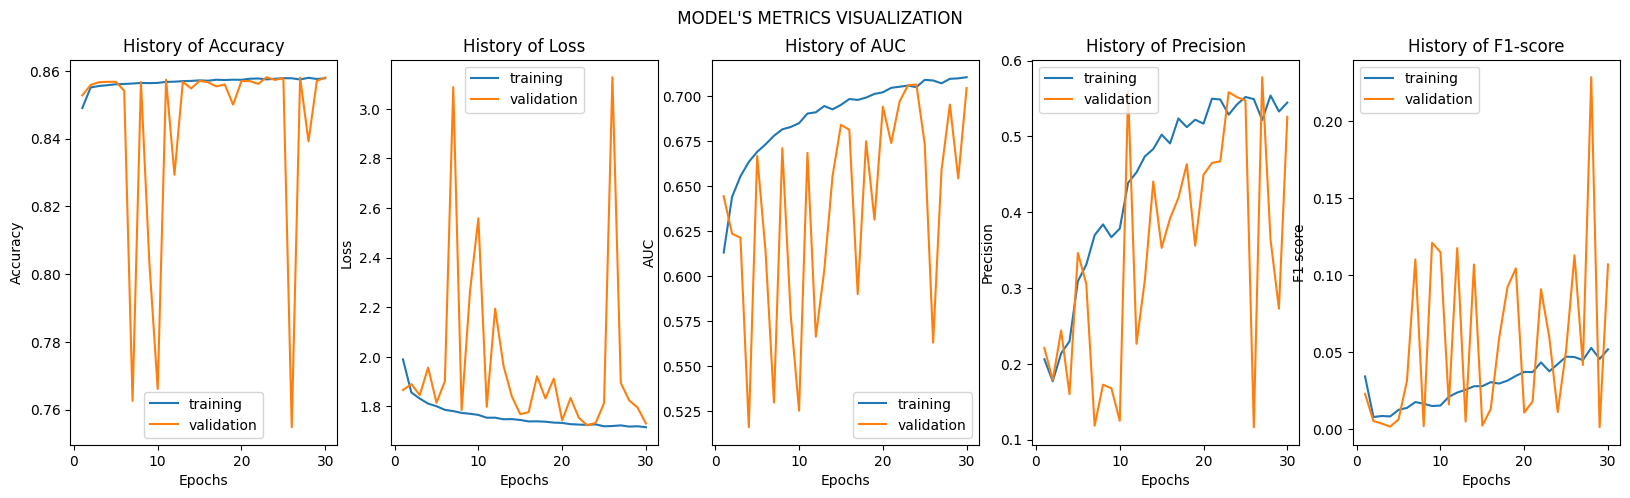

In [22]:
def Train_Val_Plot(acc,val_acc,loss,val_loss,auc,val_auc,precision,val_precision,f1,val_f1):
    
    fig, (ax1, ax2,ax3,ax4,ax5) = plt.subplots(1,5, figsize= (20,5))
    fig.suptitle(" MODEL'S METRICS VISUALIZATION ")

    ax1.plot(range(1, len(acc) + 1), acc)
    ax1.plot(range(1, len(val_acc) + 1), val_acc)
    ax1.set_title('History of Accuracy')
    ax1.set_xlabel('Epochs')
    ax1.set_ylabel('Accuracy')
    ax1.legend(['training', 'validation'])

    ax2.plot(range(1, len(loss) + 1), loss)
    ax2.plot(range(1, len(val_loss) + 1), val_loss)
    ax2.set_title('History of Loss')
    ax2.set_xlabel('Epochs')
    ax2.set_ylabel('Loss')
    ax2.legend(['training', 'validation'])
    
    ax3.plot(range(1, len(auc) + 1), auc)
    ax3.plot(range(1, len(val_auc) + 1), val_auc)
    ax3.set_title('History of AUC')
    ax3.set_xlabel('Epochs')
    ax3.set_ylabel('AUC')
    ax3.legend(['training', 'validation'])
    
    ax4.plot(range(1, len(precision) + 1), precision)
    ax4.plot(range(1, len(val_precision) + 1), val_precision)
    ax4.set_title('History of Precision')
    ax4.set_xlabel('Epochs')
    ax4.set_ylabel('Precision')
    ax4.legend(['training', 'validation'])
    
    ax5.plot(range(1, len(f1) + 1), f1)
    ax5.plot(range(1, len(val_f1) + 1), val_f1)
    ax5.set_title('History of F1-score')
    ax5.set_xlabel('Epochs')
    ax5.set_ylabel('F1 score')
    ax5.legend(['training', 'validation'])


    plt.show()
    

Train_Val_Plot(
    history.history['accuracy'],history.history['val_accuracy'],
    history.history['loss'],history.history['val_loss'],
    history.history['auc'],history.history['val_auc'],
    history.history['precision'],history.history['val_precision'],
    history.history['f1_score'],history.history['val_f1_score']
)